### ***LA INFORMACIÓN CONTENIDA EN ESTE DOCUMENTO ES PROPIEDAD DE CITIBANAMEX. SE COMPARTE CON PROPÓSITOS ACADÉMICOS Y DEBE SER TRATADA CON CARÁCTER CONFIDENCIAL.***

# Introducción al Capstone Future spend given first trial of credit card cancelation

## Descripción del proyecto

1) El Proyecto está enfocado a temas de retención. Cuando un cliente llama al call center para cancelar su tarjeta, el ejecutivo le ofrece varias “ofertas” como la anualidad, puntos premia (que son monetizables), rewards (que se redimen en productos) o una suma de líneas, con la finalidad de que el cliente decline a su petición de “cancelar la tarjeta”.

2)	El objetivo del proyecto es estimar la facturación futura del cliente en la tarjeta que pretende cancelar, para ver si el efecto de la “oferta” sirvió para que aumente su facturación o bien, el cliente sólo encontró una oportunidad para obtener algo “extra” del banco y aun así cancelar la tarjeta. Esto es ¿vale la pena darle la “oferta" al cliente? ¿La facturación futura incremental compensa la oferta que se le hace? Y con esto determinar si se procede a la cancelación o bien se trata de retener al cliente-tarjeta

3)	El data set y proceso que dará origen, serán las bases de retención, las cuales contienen a nivel tarjeta, los intentos de cancelación y la oferta que el ejecutivo realizó al momento de la llamada.

4)	El beneficio de negocio esperado será un ahorro en las “ofertas” que se le darán al cliente. Si el cliente no se estima que tendrá un incremental de facturación, el banco se ahorrará la oferta que se le puede dar al cliente, pues no justifica la facturación el monto de la oferta, posiblemente el cliente volverá a marcar por 2da vez para concretar la cancelación

In [37]:
import pandas as pd
import numpy as np

conteo=pd.read_csv('conteo.csv', encoding='latin-1')
display(conteo)

,Mes_Fecha,Cuentas,CuentasDistintas
0,01Aug2015,"99,544","99,497"
1,01-sep-15,"191,127","190,119"
2,01-oct-15,"287,023","284,146"
3,01-nov-15,"385,602","379,863"
4,01Dec2015,"483,132","473,545"
5,01Jan2016,"574,982","560,837"
6,01-feb-16,"661,720","642,965"
7,01-mar-16,"756,744","731,995"
8,01Apr2016,"845,842","814,645"
9,01-may-16,"932,000","893,763"


La base de datos es un acumulado mensual desde agosto 2015. Para fines de esta entrega, la exploración será basada en el mes de julio 2018, el cual cuenta con 1,290,271 registros.

## Diccionario de Datos

Para fines del capstone, las variables PII de empleado se quitaron de esta muestra. Además, las variables referentes de número de cliente, cuenta y plástico han sido reemplazadas por números consecutivos.

Nuestra base de datos cuenta con las siguientes variables las cuales son:

In [3]:
train=pd.read_csv('RANDRETENCION_V2.csv', encoding='latin-1')

index_vars=train.columns

variables=pd.read_csv('variables2.csv',encoding='latin-1')
vars_desc=variables[:]
vars_desc.set_index('Name', inplace=True)
i=0
for i in index_vars:
    vars_desc.loc[i,'Tipo de dato']=train[i].dtype
    
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 3)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(vars_desc)

,Descripcion,Tipo de dato
Name,,
Mes_Fecha,Fecha a la que hace referencia la información del registro,object
descontar,Campo de observaciones de la operación,object
tit_adi,Indicador que define si el intento de cancelación corresponde a una cuenta Titular o es de una tarjeta adicional,object
grupal,Grupal al que pertenece el ejecutivo,object
causa,"Descripción de razón por la que el cliente intenta cancelar, tal como fue capturada en sistema Evolución",object
subCausa,"Descripción a más detalle del por qué el cliente intentó cancelar, tal como se registró en sistema",object
cat_sucursal,Sucursal del Centro de Atención Telefónica donde se está atendiendo la llamada,object
tipo_producto,Si es uniproducto o multiproducto,object
donde_aplico,"Describe la forma en que se atendió la ejecución que se dio a la llamada:\n* Ajuste Sal, la TC fue cancelada anteriomente y ahora se solicita la eliminación de CA \n* CAT, grupal que transfirio la llamadas a Retención \n* En Linea, que el beneficio fue aplicado en línea (eCRM) \n* Papeleta, que el beneficio fue aplicado en proceso manual \n* Por Servic, no es intento de cancalación, solicitan la bonficación de comisión por rep \n* Proceso MAI, la bonficación de CA y/o ints la solicita a Mesa de atención integral (operaciones) \n",object


Lo que concluimos de la entrega del Hito 3 es que no ibamos a considerar la variables de la base de retención que son de otras fuentes, pues consideramos que estaban mal extraidas. Por lo tanto, de la base de retención sólo nos vamos a quedar con las siguientes variables:

In [38]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='VarsRetencion')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variable,Descripción
0,tit_adi,Si la tarjeta pertenece al titular o es una adicional
1,grupal,Call center al que llamó
2,causa,Motivo del intento de cancelación
3,subCausa,Detalle del intento de cancelación
4,cat_sucursal,Si entró por sucursal o por el CAT
5,tipo_producto,Producto que cancela
6,donde_aplico,Describe la forma en que se atendió la ejecución que se dio a la llamada
7,beneficio2,Detalle del beneficio
8,Beneficio_Otorgado,Beneficio Otorgado al cliente


## Metodología

A continuación se presenta un diagrama de cómo haremos la extracción de datos de diferentes fuentes, la base con la que triangularemos y poder llegar después de unos filtros a nuestra base pivote.

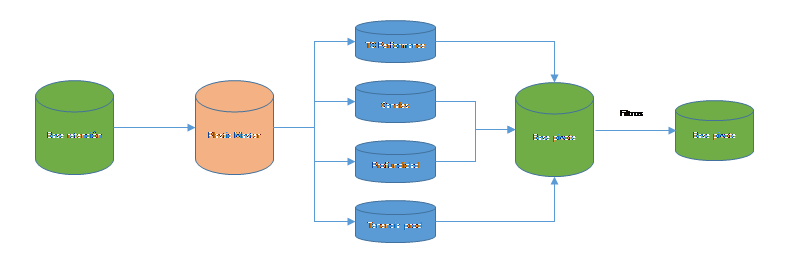

Una vez que tengamos nuestra base pivote, haremos un tratamiento de valores ausentes y la creación de features.

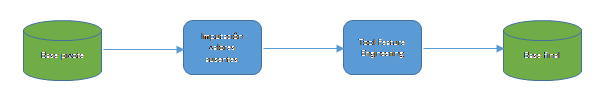

Posteriormente probaremos 2 algoritmos de Machine Learning para poder modelar y poder comparar ambas metodologías

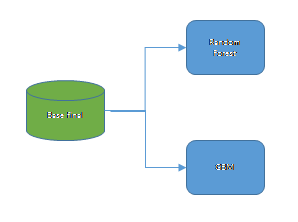

## Data Gathering y Data Pull

Con la finalidad de poder hacer todo en la plataforma de Big Data con la que cuenta el banco, tenemos a nuestra disposición un sandbox (gcgedfsmxpysp) en el cual hicimos la ingesta de las siguientes bases de datos:

   ***1.Perofmance de Tarjetas de Crédito*** - Contiene información relacionada a la cuenta, como saldo, línea de crédito, Months on books, Months Past Due, si está abierta o cerrada, compras y pagos (tanto en monto como en número de transacciones), intereses, etc. - agregadas a nivel cuenta
   
   ***2.Transaccions por canal*** - Esta base contiene información de los diferentes canales del banco tales como ATM, SAB (Sucursal Automática Banamex), TPV (terminal punto de venta o POS en inglés), Audiomático (teléfono), sucursal, corresponsal (supermecados), banca electrónica, aplicación móvil, tanto en número como en monto de transacciones - agregadas a nivel cliente
   
   ***3. Base de tenencia de productos*** - Esta base contiene la cantidad de productos abiertos/activos con los que cuenta el cliente dentro del banco tales como: Cuenta Eje (y sus respectivas componentes de cuenta de débito: Cuenta Maestra, Perfiles, Perfil Ejecutivo, Otros débitos), créditos (tarjetas, personales, de nómina, hipotecas), seguros (vida y no vida), inversiones (a plazo y vista) - agregadas a nivel cliente
   
   ***4. Profundidad de clientes*** - Base que contiene información como edad y antigüedad del cliente, la suma de sus saldos de captación (cuentas eje + inversiones) - agregadas a nivel cliente.
    
Estas bases de datos se generan mensualmente por parte del equipo de insumos y que serán nuestras bases de datos con las cuales extraeremos la historia de 6 meses atrás de nuestro mes "cohort" (julio 2018) con la finalidad de que sean nuestras variables independientes.

En nuestra base "pivote" (base de retención a julio 2018) tiene como ID el número de plástico. En las bases que ingestamos, tenemos 3 tipos de "keys" o ID: el número de cuenta, el número del plástico y el número de cliente. Con la finalidad de que podamos cruzar nuestra base pivote hicimos la ingesta de la siguiente base:

   ***Plastic Master*** - Base que tiene el número de plástico, el número de cuenta asociado a ese plástico y el número de cliente asociado a esa cuenta.
   
De las bases de datos que ingestamos, sólo consideramos las siguientes variables:
   



In [30]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='Variables')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variable,Fuente
0,MONTHSPASTDUE,Performance de Tarjetas
1,MONTHSONBOOKS,Performance de Tarjetas
2,BALANCE,Performance de Tarjetas
3,PURCHASE,Performance de Tarjetas
4,PURCHASETX,Performance de Tarjetas
5,PAYMENT,Performance de Tarjetas
6,PAYMENTTX,Performance de Tarjetas
7,CREDITLINE,Performance de Tarjetas
8,ANNUALFEE,Performance de Tarjetas
9,NCL,Performance de Tarjetas


La nomenclatura que usaremos para diferenciar los meses que vamos a considerar de historia es la siguiente:

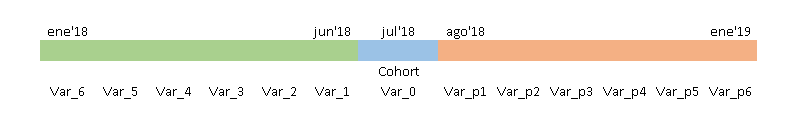

Con la finalidad de construir una variable objetivo, sólamente la fuente "Performance de Tarjetas" es la que tomaremos para el periodo de performance de los siguientes 6 meses después del cohort.

Una vez que realizamos el join de las bases con nuestra base pivote, tenemos en total las siguientes variables:
    
    
En las revisiones que tuvimos con nuestro manager del proyecto, acordamos realizar las siguientes exclusiones:
    
   - Quitamos clientes que en el mismo mes "cohort" (julio 2018) aparecen más de 1 vez.
   - Quitamos clientes que no tengan ni 1 año de antigüedad
   - Consideramos sólo clientes "Titulares"
   - Sólo consideramos a clientes con una suma de compras de los últimos 6 meses > 0 
   - Clientes que sí se retuvieron

De lo anterior tenemos el siguiente decantamiento:

In [9]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='Decantamiento')
 
display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Exclusión,Filtro,Permanecen
0,Universo Inicial,0,1290271
1,Registros únicos (cohort),232292,1057979
2,MOB>12,497383,560596
3,Compras>0,213130,347466
4,Titulares,51558,295908
5,Retenidos,132449,163459


De esta forma, nuestra base nos queda de 163,459 registros.

## Clasificación de clientes

Procedemos ahora a apalancarnos de una definición interna que existe de clientes "Spenders". Esta clasifiación consta de los siguientes rangos:

   - Clientes que gastan más de 20k pesos al mes

   - De 10k y 20k mensuales

   - De 6.5k a 10k

   - De 4.5k a 6.5k

   - De 3k a 4.5k

   - Menos de 3k mensuales

La clasificación se basa en el promedio de compras de los últimos 6 meses (sin considerar el mes cohort o "_0" en nuestra nomenclatura).

Con base en esta clasificación, tenemos que nuestra base de desarrollo de 163k registros cuenta con la siguiente distribución.

In [7]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
 
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='TipoSpender')
 
display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Tipo Spender,Num Clientes,%Clientes
0,1. 20K+ Monthly,10772,0.065900
1,2. 10K-20K Monthly,18270,0.111771
2,3. 6.5K-10K Monthly,15994,0.097847
3,4 4.5K-6.5K Monthly,15847,0.096948
4,5 3K-4.5K Monthly,18105,0.110762
5,6. <=3K Monthly,84471,0.516772
6,Total general,163459,1.000000


Para poder ver si la acción de retención fue o no efectiva, y con la finalidad de poder tener una variable objetivo, consideraremos la suma de las compras de los siguientes 6 meses (sin considerar el mes de retención "cohort" julio 2018). Una vez teniendo la suma de las compras posteriores, procedemos a hacer la variación porcentual de las compras en el periodo de performance vs el periodo de observación, para ver el porcentaje en el cliente que aumentó o disminuyó sus compras en esa tarjeta. De esta forma, tenemos que:

In [8]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='Variacion')
 
display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,∆% Spend,Num Clientes,% Clientes
0,01. 90%+,36692,0.224472
1,02. 80%-90%,2574,0.015747
2,03. 70%-80%,2825,0.017283
3,04. 60%-70%,3219,0.019693
4,05. 50%-60%,3610,0.022085
5,06. 40%-50%,3966,0.024263
6,07. 30%-40%,4623,0.028282
7,08. 20%-30%,5151,0.031512
8,09. 10%-20%,5678,0.034737
9,10. 0%-10%,6952,0.042531


Si consideramos a los clientes que tuvieron una caida en sus compras, tenemos que:

In [13]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='ClientesCaida')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variacion / Tipo Spender,1. 20K+ Monthly,2. 10K-20K Monthly,3. 6.5K-10K Monthly,4 4.5K-6.5K Monthly,5 3K-4.5K Monthly,6. <=3K Monthly,Total
0,11. (10)%-0%,788,1183,870,750,791,2251,6633
1,12. (20)%-(10)%,838,1153,871,806,782,2159,6609
2,13. (30)%-(20)%,868,1139,844,796,796,2080,6523
3,14. (40)%-(30)%,785,1048,885,763,757,2184,6422
4,15. (50)%-(40)%,727,1019,771,727,815,2179,6238
5,16. (60)%-(50)%,626,974,778,723,776,2154,6031
6,17. (70)%-(60)%,527,842,718,694,791,2270,5842
7,18. (80)%-(70)%,493,767,676,729,771,2339,5775
8,19. (90)%-(80)%,416,708,653,728,799,2599,5903
9,20. <(90)%,670,1597,1629,2023,2769,23505,32193


Podemos ver que 88k clientes presentaron una caída en su facturación de un periodo a otro. Estos clientes representan una caída en monto de 3 mil millones de pesos, los cuales se presentan a continuación:

In [35]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='MontoCaida')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variacion / Tipo Spender,1. 20K+ Monthly,2. 10K-20K Monthly,3. 6.5K-10K Monthly,4 4.5K-6.5K Monthly,5 3K-4.5K Monthly,6. <=3K Monthly,Total
0,11. (10)%-0%,156.388813,83.295980,35.216456,20.412690,14.570781,17.025343,326.910064
1,12. (20)%-(10)%,155.052200,80.947126,35.362932,22.027966,14.470954,16.161036,324.022213
2,13. (30)%-(20)%,168.386898,79.458066,34.184336,21.783880,14.787692,15.845712,334.446583
3,14. (40)%-(30)%,151.885237,73.597209,35.660308,20.859736,13.956985,16.647644,312.607120
4,15. (50)%-(40)%,142.267420,72.721494,31.162669,19.965929,15.097302,16.246426,297.461240
5,16. (60)%-(50)%,119.659078,69.091960,31.432027,19.576155,14.154427,16.400475,270.314122
6,17. (70)%-(60)%,103.861280,58.431513,29.122341,18.801145,14.691059,16.439894,241.347233
7,18. (80)%-(70)%,89.353099,53.441901,27.435253,19.833451,14.219136,17.351230,221.634070
8,19. (90)%-(80)%,78.370710,49.570337,26.138941,19.733891,14.845956,18.697719,207.357555
9,20. <(90)%,116.325850,109.562756,65.484552,54.554380,50.947961,107.108811,503.984310


Sin embargo, así como hay clientes que tuvieron una caída en su facturación, también hubo clientes que tuvieron un aumento en la misa. Los clientes que aumentaron son:

In [15]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='ClientesAumenta')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variacion / Tipo Spender,1. 20K+ Monthly,2. 10K-20K Monthly,3. 6.5K-10K Monthly,4 4.5K-6.5K Monthly,5 3K-4.5K Monthly,6. <=3K Monthly,Total
0,01. 90%+,602,1737,2167,2573,3433,26180,36692
1,02. 80%-90%,142,316,350,312,342,1112,2574
2,03. 70%-80%,168,383,343,353,383,1195,2825
3,04. 60%-70%,212,471,420,363,426,1327,3219
4,05. 50%-60%,258,551,496,433,465,1407,3610
5,06. 40%-50%,362,668,575,494,481,1386,3966
6,07. 30%-40%,443,810,631,599,582,1558,4623
7,08. 20%-30%,549,843,740,608,611,1800,5151
8,09. 10%-20%,603,992,755,663,726,1939,5678
9,10. 0%-10%,695,1069,822,710,809,2847,6952


Estos 75k clientes representan un aumento en facturación de 2.1 mil millones de pesos. Esto es preocupante porque el monto neto de facturación es negativo, pues hubo más disminución que aumento en estos clientes. Eta es una justificación potencial de este proyecto para poder implementarlo con Gerencia de Producto.

In [16]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='MontoAumenta')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variacion / Tipo Spender,1. 20K+ Monthly,2. 10K-20K Monthly,3. 6.5K-10K Monthly,4 4.5K-6.5K Monthly,5 3K-4.5K Monthly,6. <=3K Monthly,Total
0,01. 90%+,101.257364,118.724423,86.813252,69.246310,63.212744,130.706867,569.960960
1,02. 80%-90%,24.055295,21.368846,14.124292,8.481315,6.341040,8.047519,82.418308
2,03. 70%-80%,27.768364,26.367670,13.732905,9.568231,7.128006,8.929657,93.494833
3,04. 60%-70%,38.818132,32.556824,17.088849,9.811702,7.918587,9.997720,116.191813
4,05. 50%-60%,43.139111,37.901836,20.140214,11.730505,8.633410,10.606833,132.151910
5,06. 40%-50%,67.122173,45.923320,23.219028,13.546703,8.912192,10.288881,169.012296
6,07. 30%-40%,79.228320,55.630037,25.600014,16.230801,10.873141,11.766113,199.328426
7,08. 20%-30%,95.891574,59.336705,29.882979,16.507776,11.372395,13.664322,226.655750
8,09. 10%-20%,119.486524,69.117880,30.482798,17.987230,13.489376,14.345188,264.908996
9,10. 0%-10%,131.309924,75.509814,33.275681,19.352205,15.010021,17.074263,291.531908


## Variable objetivo

Para poder defiir nuestra variable objetivo, nos vamos a centrar en aquellos clientes que la acción de retención provocí un aumento en su facturación en los siguientes 6 meses y de esta forma poder estimar la probabilidad de que un cliente aumente o no su facturación.

Considerando clientes que tuvieron un aumento en su facturación (75k clientes) por un monto de 2.1MM de pesos, al verlo de forma porcentual vs total de clientes y total de monto que aumentaron, tenemos:

In [19]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='PctCtes')
df2 = pd.read_excel('EntregaCapstone.xlsx', sheetname='PctMonto')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
print("Porcentaje de clientes vs total de clientes con aumento")
display(df)
print("Porcentaje de monto vs total de monto con aumento")
display(df2)

Porcentaje de clientes vs total de clientes con aumento


C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variacion / Tipo Spender,1. 20K+ Monthly,2. 10K-20K Monthly,3. 6.5K-10K Monthly,4 4.5K-6.5K Monthly,5 3K-4.5K Monthly,6. <=3K Monthly,Total general
0,01. 90%+,0.007996,0.023071,0.028782,0.034175,0.045597,0.347722,0.487342
1,02. 80%-90%,0.001886,0.004197,0.004649,0.004144,0.004542,0.014770,0.034188
2,03. 70%-80%,0.002231,0.005087,0.004556,0.004689,0.005087,0.015872,0.037522
3,04. 60%-70%,0.002816,0.006256,0.005578,0.004821,0.005658,0.017625,0.042755
4,05. 50%-60%,0.003427,0.007318,0.006588,0.005751,0.006176,0.018688,0.047948
5,06. 40%-50%,0.004808,0.008872,0.007637,0.006561,0.006389,0.018409,0.052676
6,07. 30%-40%,0.005884,0.010758,0.008381,0.007956,0.007730,0.020693,0.061403
7,08. 20%-30%,0.007292,0.011197,0.009829,0.008075,0.008115,0.023908,0.068415
8,09. 10%-20%,0.008009,0.013176,0.010028,0.008806,0.009643,0.025754,0.075415
9,10. 0%-10%,0.009231,0.014198,0.010918,0.009430,0.010745,0.037814,0.092336


Porcentaje de monto vs total de monto con aumento


,Variacion / Tipo Spender,1. 20K+ Monthly,2. 10K-20K Monthly,3. 6.5K-10K Monthly,4 4.5K-6.5K Monthly,5 3K-4.5K Monthly,6. <=3K Monthly,Total general
0,01. 90%+,0.047192,0.055332,0.040460,0.032273,0.029461,0.060917,0.265635
1,02. 80%-90%,0.011211,0.009959,0.006583,0.003953,0.002955,0.003751,0.038412
2,03. 70%-80%,0.012942,0.012289,0.006400,0.004459,0.003322,0.004162,0.043574
3,04. 60%-70%,0.018092,0.015173,0.007964,0.004573,0.003691,0.004660,0.054152
4,05. 50%-60%,0.020105,0.017664,0.009387,0.005467,0.004024,0.004943,0.061590
5,06. 40%-50%,0.031283,0.021403,0.010821,0.006314,0.004154,0.004795,0.078770
6,07. 30%-40%,0.036925,0.025927,0.011931,0.007564,0.005068,0.005484,0.092899
7,08. 20%-30%,0.044691,0.027654,0.013927,0.007694,0.005300,0.006368,0.105635
8,09. 10%-20%,0.055688,0.032213,0.014207,0.008383,0.006287,0.006686,0.123463
9,10. 0%-10%,0.061198,0.035192,0.015508,0.009019,0.006996,0.007958,0.135871


Con nuestra manager del proyecto acordamos ignorar la categoría de spender "6.<=3k Monthly" y quedarnos con el resto. De esta forma, si sumamos los porcentajes capturaríamos:
    
   - el 45% de los clientes
   - el 90% del monto
   
 Esto es, con sólo considerar el 45% de los clientes con aumento, se abarcaría casi el 90% del monto total de aumento (sobre los 2.1MM de pesos). Globalmente se tendría entonces que ese 45% representa en total de los clientes (con aumento y con caída) a un 21% como se muestra en la siguiente tabla:

In [21]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='VsTotal')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)


C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variacion / Tipo Spender,1. 20K+ Monthly,2. 10K-20K Monthly,3. 6.5K-10K Monthly,4 4.5K-6.5K Monthly,5 3K-4.5K Monthly,6. <=3K Monthly,Total,%Total,Clientes objetivo,%Objetivo
0,Aumento,4034,7840,7299,7108,8258,40751,75290,0.460605,34539,0.211301
1,Caida,6738,10430,8695,8739,9847,43720,88169,0.539395,0,0.000000
2,Total,10772,18270,15994,15847,18105,84471,163459,1.000000,0,0.000000


## Missing Treatment

Una vez que tenemos nuestra base pivote después de exclusiones y unida a las demás fuentes de datos, haremos un resumen de estadísticos básicos para ver el número de valores ausentes por cada una de las variables. Para ello utilizamos las siguientes funciones:

   - df.summary()
   - Y una función definida por nosotros:

In [ ]:
columnas = [x.name for x in df.schema if (str(x.dataType)!='StringType')]

resumen = pd.DataFrame(np.nan, index=range(0,len(columnas)),columns=['p1','p5','p10','p90','p95','p99'])

for col_name in columnas:
    resumen.loc[m,'p1']=df.approxQuantile(col_name, [0.01], 0)[0]
    resumen.loc[m,'p5']=df.approxQuantile(col_name, [0.05], 0)[0]
    resumen.loc[m,'p10']=df.approxQuantile(col_name, [0.1], 0)[0]
    resumen.loc[m,'p90']=df.approxQuantile(col_name, [0.9], 0)[0]
    resumen.loc[m,'p95']=df.approxQuantile(col_name, [0.95], 0)[0]
    resumen.loc[m,'p99']=df.approxQuantile(col_name, [0.99], 0)[0]
    m=m+1

Ambas nos dan todos los percentiles que necesitamos para poder tener una buena estadística descriptiva por variable.

In [25]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='Summary')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,summary,Schema,count,NMISS,PctNMISS,mean,stddev,min,P25,P50,P75,max
0,MONTHSPASTDUE_0,smallint,163459,0,0.000000,0.036052,0.330814,0.00000,0.000000,0.000000,0.000000,7.000000e+00
1,MONTHSONBOOKS_0,smallint,163459,0,0.000000,73.967521,74.234042,13.00000,28.000000,53.000000,83.000000,5.940000e+02
2,BALANCE_0,double,163459,0,0.000000,14488.081385,27490.348759,-762573.64000,756.750000,5246.980000,16574.300000,1.095899e+06
3,PURCHASE_0,double,163459,0,0.000000,5795.532204,14651.700812,-68133.70000,0.000000,1468.700000,5924.990000,1.076163e+06
4,PURCHASETX_0,double,163459,0,0.000000,6.644675,11.418472,-9.00000,0.000000,2.000000,8.000000,2.820000e+02
5,PAYMENT_0,double,149014,14445,0.088371,6668.164461,14104.614786,0.00000,800.230000,2606.910000,7074.940000,1.071142e+06
6,PAYMENTTX_0,double,149014,14445,0.088371,1.437348,1.521277,0.00000,1.000000,1.000000,2.000000,6.900000e+01
7,CREDITLINE_0,double,157902,5557,0.033996,81177.803093,91953.264750,1000.00000,22000.000000,50004.000000,102500.000000,2.000000e+06
8,ANNUALFEE_0,double,149015,14444,0.088365,95.718842,395.404640,-3300.00000,0.000000,0.000000,0.000000,1.601600e+04
9,NCL_0,double,163458,1,0.000006,4.653464,967.761553,0.00000,0.000000,0.000000,0.000000,3.749936e+05


Utilizamos una función de Spark que hace una imputación de valores ausentes. Esta función no se ejecuta cuando toda la variable es missing, por lo cual las podemos identificar, ya sea con el resumen mostrado anteriormente en la columna de NMISS o bien con el error que te arroja esa función. Las variables que son 100% valores ausentes para todos los meses son:

In [26]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='VarsTodoMissing')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variables,Schema,%MISS
0,TNX_ATM_OLD,double,1
1,IMP_ATM_OLD,double,1
2,TNX_ATM_NO_FIN_OLD,double,1
3,IMP_ATM_NO_FIN_OLD,double,1
4,TNX_SAB_ATM_OLD,double,1
5,IMP_SAB_ATM_OLD,double,1
6,TNX_CORR_FIN,double,1
7,IMP_CORR_FIN,double,1
8,TNX_SIM,double,1
9,IMP_SIM,double,1


Del resto de las variables, se hizo la imputación de la siguiente forma:

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=columnas, outputCols=["{}_imputed".format(c) for c in columnas])

df_imputado=model.transform(df)

De esta forma, se imputaron todas las variables que aparecen en la base pivote que no son Strings y se conserva tanto la variable original, como la variable imputada con un sufijo "_imputed".

Esta función imputa con la media de la distribución por variable, salvo si se le pide imputar por la mediana o bien imputar un valor específico por otro valor. Lo que se realizó fue una imputación con la media.

La "nueva" distribución de las variables después de la imputación es:

In [36]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='SummaryImputed3')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,summary,imputed,count,mean,stddev,min,P25,P5,P75,max
0,ATM_NF_2_imputed,1,163459,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000e+00
1,SUCU_0_imputed,1,163459,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000e+00
2,PRODUCTOS_1_imputed,1,163459,4.902265,2.694432,1.00,3.000000,5.000000,7.000000,2.500000e+01
3,HIPOTECANVO_3_imputed,1,163459,0.021343,0.208613,0.00,0.000000,0.000000,0.000000,6.000000e+00
4,IMP_CSR_NO_FIN_3_imputed,1,163459,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000e+00
5,NFN_ATM_ENQRY_0_imputed,1,163459,1.798587,0.234707,1.00,1.798587,1.798587,1.798587,1.900000e+01
6,IMP_SAB_2_imputed,1,163459,5588.907067,3733.082552,1.00,5588.907067,5588.907067,5588.907067,1.706000e+05
7,APP_2_imputed,1,163459,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000e+00
8,TPV_1_imputed,1,163459,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000e+00
9,CSR_NF_2_imputed,1,163459,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000e+00


## Feature Engineering

Una vez imputados los valores ausentes de cada una de las variables, se procedió a usar un Tool interno que desarrolló el equipo de Data & Analytics de Citibanamex. Este tool genera las diferentes combinaciones trimestrales de diferentes features, tales como media, mediana, mínimo, máximo, transformaciones logarítmicas, etc de una manera eficiente. Este tool se basa en un diccionario de las variables a las que se les quiere aplicar dichos features. El diccionario que nosotros usamos consta de las siguientes variables:

In [28]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='DiccionarioTools')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variable
0,BALANCE_i
1,CAPTACION_i
2,IMP_APP_i
3,IMP_ATM_i
4,IMP_BANCANET_PERS_i
5,IMP_IVR_i
6,IMP_SAB_i
7,IMP_SUC_FIN_i
8,IMP_TPV_i
9,INGRESOS_i


Sólo consideramos estas variables pues son las que nosotros ubicamos como "continuas" y que hace sentido hacer transformaciones. Variables puntuales como línea de créito, edad, Months on books, y flags de tenencia de productos no hace sentido calcular un feature, pues preferimos quedarnos sólo con el valor más reciente.

De esta forma se generaron las siguientes bases:

   - Means - Promedio de los últimos 6 meses
   - StdDev - Desviación estándar de los últimos 6 meses
   - Sum - Suma de los últimos 6 meses
   - Min - Mínimo de los últimos 6 meses
   - Max - Máximo de los últimos 6 meses
   - Log - Logaritmo de los últimos 6 meses

Acordamos con nuestra mentora del proyecto que desechemos las variables "brutas" y nos quedemos únicamente con los "features" creados. Las variables categóricas relacionadas a la base propia de retención se usarán después de tener un modelo y mediante "analytics" ver el grupal, producto y beneficio en donde se concentran los clientes con más probabilidad de aumentar su facturación. De esta forma podemos obtener por cada combinación un Net Credit Margin promedio y calcular el monto de beneficio "límite" por combinación. Esto es como paso siguiente al desarrollo del modelo.

Por lo tanto, nuestra base de datos final tiene las siguientes variables:

In [29]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='VarsFinales')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Variable,Tipo de Variable,Origen
0,crd_nbr,ID,Retención
1,id_msf_tools_v2_12315,ID,Feature
2,tit_adi,Categórica,Retención
3,grupal,Categórica,Retención
4,causa,Categórica,Retención
5,subCausa,Categórica,Retención
6,cat_sucursal,Categórica,Retención
7,tipo_producto,Categórica,Retención
8,donde_aplico,Categórica,Retención
9,beneficio2,Categórica,Retención


## Modelo

Para poder utilizar las funciones de Spark ML, necesitamos tener nuestra base final en donde todas las variables independientes formen un vector y de manera separada la variable independiente. Para ello hicimos lo siguiente:

In [ ]:
columnas = [x.name for x in base.schema if  str(x.dataType)!='StringType']
columnas.remove('target')
columnas.remove('id_msf_tools_v2_12315')
columnas.remove('D_Purchase_V2')


variables = base.select(columnas+["target"])
assembler = VectorAssembler(inputCols=columnas,outputCol="features")
output = assembler.transform(variables.na.fill(0))
data = output.select(col("features"),col("target").alias("label"))

De esta forma, nuestra base "data" ya cuenta con solo 2 columnas: features (vector que contiene las variables independientes) y label (que contiene la variable objetivo).

Con la finalidad de poder comparar modelos, vamos a utilizar 2 diferentes algoritmos de clasificación: Random Forest y GBM.

En ambos casos utilizamos un Cross Vallidation (con folds=5) para poder tener diferentes muestras de desarrollo y de validación.

### a) Random Forest

Utilizando la función "RandomForestClassifier" utilizamos los siguientes parámetros:

  - Subsampling Rate - 50% - Tasa en la que el RF saca una muestra aleatoria de las variables independientes
  - Profundidad - 6 - Número de niveles de cada árbol
  - Número de iteraciones - 5,000 - número de árboles que se generarán
  
Este algoritmo con estos parámetros nos dio los siguientes resultados:

Missclassification Rate: 19.37%

Y la siguiente matriz de confusión:

In [41]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='RF2')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Predicted = 0,Predicted = 1,Unnamed: 2
Actual = 0,6483,3616,10099
Actual = 1,28056,125304,153360
NaN,34539,128920,163459


### b) GBM

Utilizando la función "RandomForestClassifier" utilizamos los siguientes parámetros:

  - Learning Rate - 10% - Tasa de "encogimiento" a la que el algoritmo utiliza el gradiente y da un "paso" para poder encontrar un máximo o mínimo local.
  - Profundidad - 6 - Número de niveles de cada árbol
  - Número de iteraciones - 100 - número de árboles que se generarán
  
Este algoritmo con estos parámetros nos dio los siguientes resultados:

Missclassification Rate: 15.34%

Y la siguiente matriz de confusión:

In [40]:
df = pd.read_excel('EntregaCapstone.xlsx', sheetname='GBM2')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 13)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(df)

C:\Users\mz90328\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,Predicted = 0,Predicted = 1,Unnamed: 2
Actual = 0,20376,10917,31293
Actual = 1,14163,118003,132166
NaN,34539,128920,163459


## Comparativo

Basados en el porcentaje de acierto o accuracy de cada uno de los modelos, podríamos concluir que el GBM resuló mejor que el Random Forest. Sin embargo, tendríamos que tener algún estadístico adicional para poder decidir cuál de los 2 modelos es mejor.

## Conclusión

A lo largo del Diplomado en Ciencia de Datos del ITAM, hemos aprendido a usar diferentes herramientas, las cuales varias de ellas tenemos acceso en la plataforma de Big Data de Citibanamex. Entre esas herramientas está el uso de Spark y Python, los cuales nos permiten hacer nuestro trabajo del día a día sin tener una dependencia de un servidor y de un software limitado en espacio y en capacidad de procesar una cantidad de datos demasiado grande.

Hemos aprendido en el Hito 3 a hacer una exploración de datos, basado en una muestra debido al requisito de tener gráficos. Y para esta entrega final hemos aprendido a hacer modelos utilizando diferentes algoritmos de Machine Learning, los cuales vimos a detalle lo que hace cada uno de ellos y sus parámetros (tanto lo que significan como los valores que podemos poner).

Un gran valor agregado de las clases del Diplomado ha sido el saber usar la página de Apache Spark, para poder consultar todas las funciones que ya están en algún paquete o librería, sus inputs y outputs.

A travéz de este entregable, aprendimos a hacer en la plataforma de Big Data lo que antes hacíamos en SAS. Esto incluye:

Extracción de variables
Limpieza de datos
Creación de variables sintéticas
Modelación
Resultados

En la parte de extracción tuvimos que hacer la ingesta de las bases de datos y toda la unión de las bases se realizó en Spark. La limpieza de datos se hizo con una función que ya existe en Spark, aunque también pudimos utilizar un tool interno de Citibanamex. PAra la creación de features sí nos apalancamos de los tools existentes dentro del equipo de Data & Analytics de Citibanamex. La modelación fue el resultado de lo visto en clases del Diplomado, así como las diferentes estadísticas que podemos obtener.

## Siguientes Pasos

Este proyecto sólo se enfocó en la creación de un modelo que estimara la probabilitidad de que un cliente aumente su facturación de un periodo de performance vs periodo de observación.

El resultado de este modelo debería usarse para hacer analytics y poder ver el grupal de retención, el beneficio otorgado y el producto a cancelar que tiene mayor concentración de los clientes con alta probabilidad de aumentar la facturación.

Como siguiente pasó, podríamos determinar vía el Net Credit Margin, cuál es el "límite" de beneficio (su valor en $) suficiente para poder retener al cliente e incentivarlo a aumentar su facturación, de lo contrario, si el cliente no sale rentable o bien es poco probable su aumento de facturación, podría tratarse de un cliente que sólo busca qué le puede sacar al banco "gratis".

Esto lo podemos utilizar "cruzando" con más modelos internos del equipo, relacionados al tema de attrition, y que podría ser un input mismo de este modelo, de tal forma que, modularmente, se pueda tener un modelo de modelos.